﻿
# 自回归移动平均

## 安装软件包

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import os
from statsmodels.tsa.arima_model import ARMA
import matplotlib.pyplot as plt
import seaborn as sns
import quiz_tests

In [3]:
sns.set()
#note that for the figure size to show, this cell should be run
#separately from the import of pyplot
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

## 模拟具有自回归属性的收益率时序

In [4]:
from statsmodels.tsa.arima_process import ArmaProcess
np.random.seed(200)

ar_params = np.array([1, -0.5])
ma_params = np.array([1, -0.3])
ret = ArmaProcess(ar_params, ma_params).generate_sample(nsample=5*252)

ret = pd.Series(ret)
drift = 100
price = pd.Series(np.cumsum(ret)) + drift

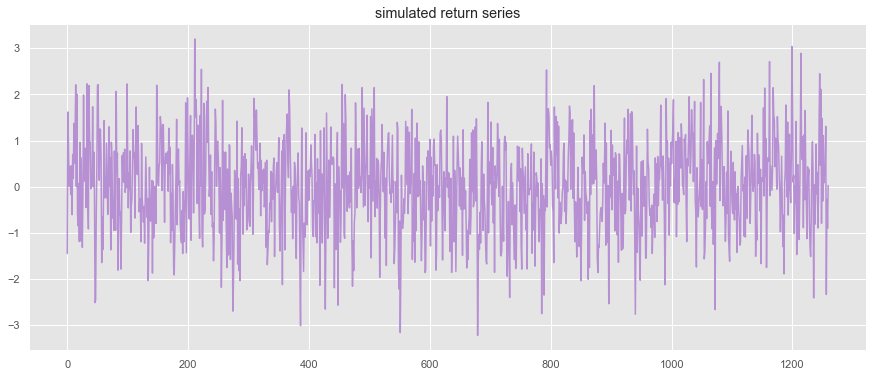

In [5]:
ret.plot(figsize=(15,6), color=sns.xkcd_rgb["pale purple"], title="simulated return series")
plt.show()

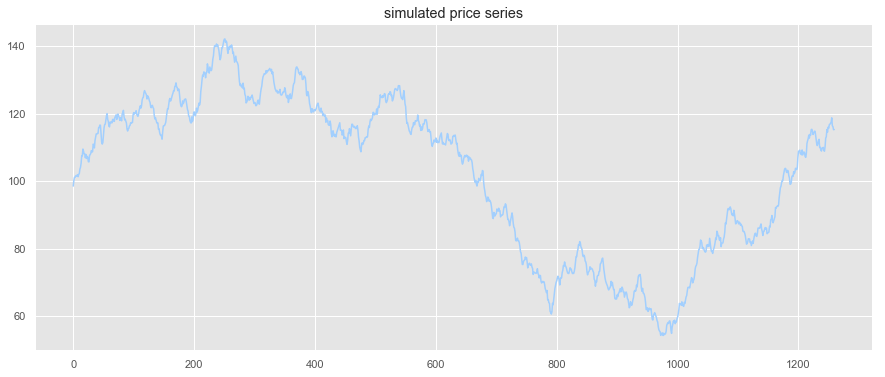

In [6]:
price.plot(figsize=(15,6), color=sns.xkcd_rgb["baby blue"], title="simulated price series")
plt.show()

### 对数收益率

In [7]:
lret = np.log(price) - np.log(price.shift(1))
lret = lret[1:]

## 自相关

通过自相关判断应该为自回归模型设置什么样的滞后值。

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

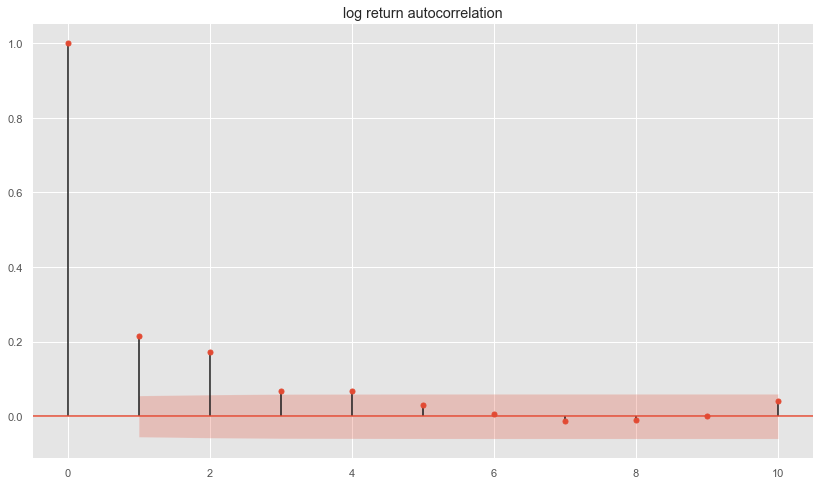

In [9]:
_ = plot_acf(lret,lags=10, title='log return autocorrelation')

因为样本时序具有自回归属性，所以当前时期和滞后值之间也有自相关性。

注意，对于实际股票数据，某一天和第二天的收益率没有太多自相关性。  
股票收益率（对数收益率和正常收益率）可以描述为“随机游动”，即每个新时期的值都比较随机。

## 偏自相关图形

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf

股价偏自相关表明大部分的相关性都在上一个时期发现的。偏自相关与自相关不同，前者展示了不能归因于导致当前时期的其他时期的每个时期带来的影响。也就是说，两天的滞后期与当前值的相关性很强，因为它与一天的滞后期有很强的相关性。但是，无法归因于一天滞后期的两天滞后期与当前时期的偏自相关性相对比较弱。

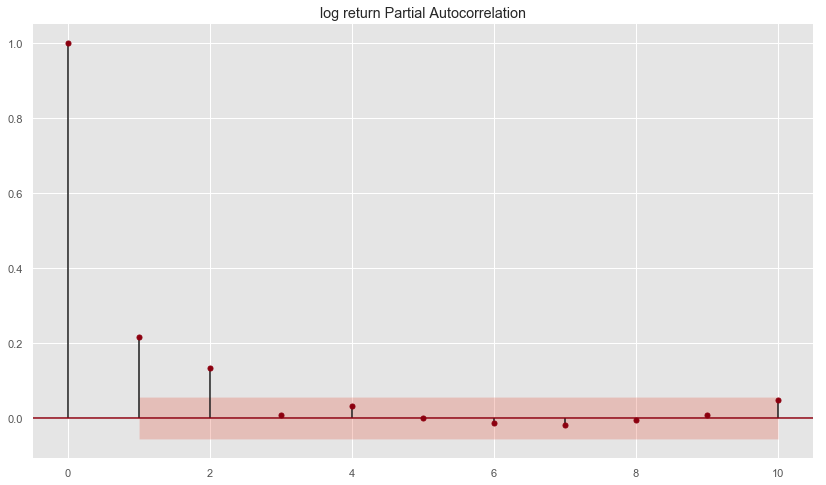

In [11]:
_ = plot_pacf(lret, lags=10, title='log return Partial Autocorrelation', color=sns.xkcd_rgb["crimson"])

## 讨论

注意之前的时期与当前时期之间的相关性不强。通常，使用过去的股票收益率预测未来收益率比较难。波动性往往与过去的波动性相关性更强。我们将在这个模块的后面课程中讨论波动性。

## Ljung-Box 检验

Ljung-Box 检验可以检查我们所选的滞后值能否得出与零偏差很大的自相关性。零假设是之前的滞后值整体上与当前时期不相关。如果 p 值很小（例如 0.05），我们可以拒绝零假设，并认为过去的滞后值与当前时期有一定的相关性。

returns:  
lbvalue (float or array) – test statistic  
pvalue (float or array) – p-value based on chi-square distribution  
... (we'll ignore the other outputs, which are for another similar hypothesis test)  

In [12]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [13]:
lb_test_stat, lb_p_value = acorr_ljungbox(lret,lags=20)
lb_p_value

array([2.01640711e-14, 1.24123312e-21, 5.10501473e-22, 1.86446247e-22,
       6.13688232e-22, 2.96811370e-21, 1.18392407e-20, 4.64232373e-20,
       1.78935377e-19, 2.36770725e-19, 5.54712773e-19, 1.32980392e-18,
       3.72359442e-18, 5.86709112e-18, 1.72205886e-17, 4.22143078e-17,
       1.15704571e-16, 9.89290170e-17, 2.59299780e-16, 1.50593115e-16])

## 讨论

因为这个时序具有自回归属性，所以 Ljung-Box 检验显示我们检验的 20 个滞后期的 p 值小于 0.05。

## 拟合 ARMA 模型

为了熟悉 ARMA 模型，我们将使模型拟合模拟的收益率时序。

我们将对自回归和移动平均使用一个滞后期。  请参阅 [statsmodel arma](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARMA.html) 文档。

In [14]:
from statsmodels.tsa.arima_model import ARMA

In [15]:
AR_lag_p = 1
MA_lag_q = 1
order = (AR_lag_p, MA_lag_q)
arma_model = ARMA(lret.values, order=order)
arma_result = arma_model.fit()
arma_pred = pd.Series(arma_result.fittedvalues)

## 查看拟合的预测值与实际值

Fitted AR parameter 0.65, MA parameter -0.45


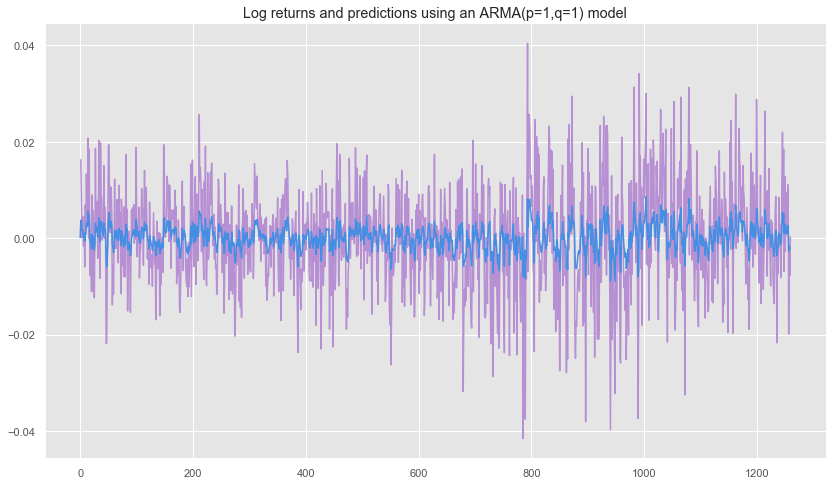

In [16]:
plt.plot(lret, color=sns.xkcd_rgb["pale purple"])
plt.plot(arma_pred, color=sns.xkcd_rgb["dark sky blue"])
plt.title('Log returns and predictions using an ARMA(p=1,q=1) model');
print(f"Fitted AR parameter {arma_result.arparams[0]:.2f}, MA parameter {arma_result.maparams[0]:.2f}")

## 讨论

通常，自回归移动平均模型无法预测股票收益率，因为股票收益率不稳定，并且噪点很多。

还有一些以 ARMA 模型为基础的其他技巧，我们的目标是帮助你熟悉这些概念，因为它们是你将在这个模块的后面课程中见到的其他模型的基础。

## 小测验：ARIMA

拟合自回归求积移动平均模型。采用一阶积分、1 个自回归滞后期和 1 个移动平均滞后期。

请参阅 [stats model arima](http://www.statsmodels.org/0.6.1/generated/statsmodels.tsa.arima_model.ARMAResults.html) 文档。

In [17]:
from statsmodels.tsa.arima_model import ARIMA

In [18]:
def fit_arima(lret):
    
    #TODO: choose autoregression lag of 1
    AR_lag_p = 1
    
    #TODO: choose moving average lag of 1
    MA_lag_q = 1
    
    #TODO: choose order of integration 1
    order_of_integration_d = 1
    
    #TODO: Create a tuple of p,d,q
    order = (AR_lag_p, order_of_integration_d, MA_lag_q)
    
    #TODO: create an ARIMA model object, passing in the values of the lret pandas series,
    # and the tuple containing the (p,d,q) order arguments
    arima_model = ARIMA(lret.values, order=order)
    
    arima_result = arima_model.fit()
    
    #TODO: from the result of calling ARIMA.fit(),
    # save and return the fitted values, autoregression parameters, and moving average parameters
    fittedvalues = arima_result.fittedvalues
    arparams = arima_result.arparams
    maparams = arima_result.maparams
   
    return fittedvalues,arparams,maparams

quiz_tests.test_fit_arima(fit_arima)

Tests Passed


fitted AR parameter 0.21, MA parameter -0.98


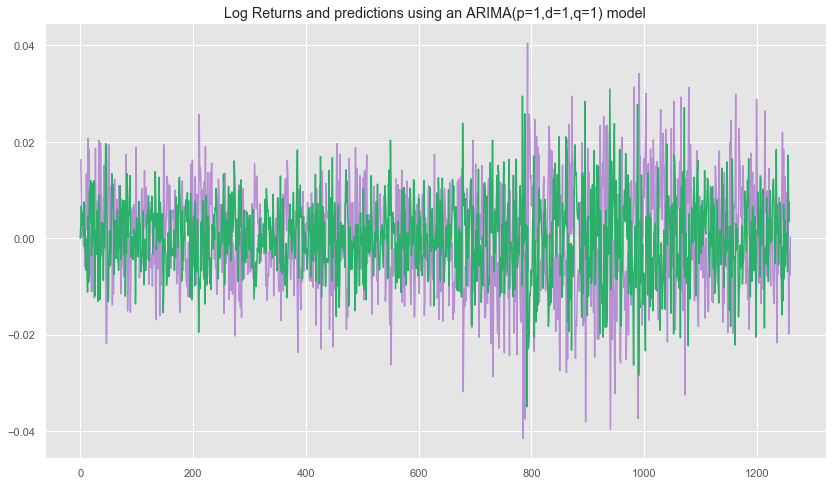

In [19]:
fittedvalues,arparams,maparams = fit_arima(lret)
arima_pred = pd.Series(fittedvalues)
plt.plot(lret, color=sns.xkcd_rgb["pale purple"])
plt.plot(arima_pred, color=sns.xkcd_rgb["jade green"])
plt.title('Log Returns and predictions using an ARIMA(p=1,d=1,q=1) model');
print(f"fitted AR parameter {arparams[0]:.2f}, MA parameter {maparams[0]:.2f}")

如果你遇到问题，请在[此处](autoregression_solution.ipynb)查看解答。